In [1]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load Data
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
# Data Preparation
# Aggregate transaction data per customer
transaction_features = transactions.groupby('CustomerID').agg({
    'TransactionID': 'count',  # Transaction frequency
    'ProductID': 'nunique',   # Product diversity
    'TransactionDate': lambda x: (pd.to_datetime(x).max() - pd.to_datetime(x).min()).days  # Recency
}).rename(columns={'TransactionID': 'Frequency', 'ProductID': 'Diversity', 'TransactionDate': 'Recency'})

In [4]:
# Merge with customer data
customer_data = customers.merge(transaction_features, on='CustomerID', how='left').fillna(0)

In [5]:
# Feature Engineering
customer_data['SignupDuration'] = (pd.Timestamp.now() - pd.to_datetime(customer_data['SignupDate'])).dt.days
customer_data = pd.get_dummies(customer_data, columns=['Region'], drop_first=True)

In [6]:
# Normalize Data
scaler = StandardScaler()
features = ['Frequency', 'Diversity', 'Recency', 'SignupDuration'] + list(customer_data.filter(like='Region_').columns)
X = scaler.fit_transform(customer_data[features])

In [7]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(X)
customer_data['Cluster'] = clusters

In [8]:
# Evaluation Metrics
db_index = davies_bouldin_score(X, clusters)
silhouette = silhouette_score(X, clusters)

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")

Davies-Bouldin Index: 1.3352250405679504
Silhouette Score: 0.29046772274620686


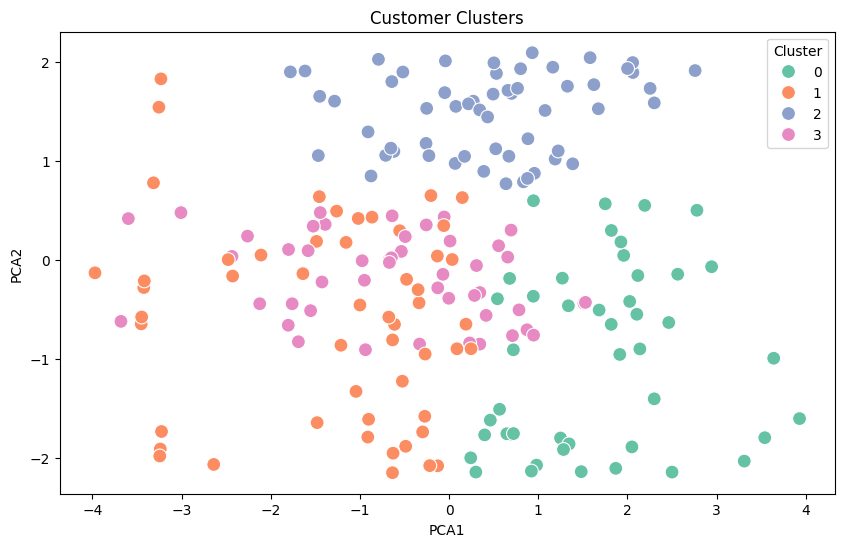

In [9]:
# Visualization
pca = PCA(n_components=2)
pca_data = pca.fit_transform(X)
customer_data['PCA1'] = pca_data[:, 0]
customer_data['PCA2'] = pca_data[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=customer_data, palette='Set2', s=100)
plt.title('Customer Clusters')
plt.show()